In [ ]:
# ======================
# Paths on Kaggle
# ======================
import os, zipfile

# Kaggle automatically puts attached datasets in /kaggle/input/
data_path = "/kaggle/input/fer2013"
extract_path = "/kaggle/working/facial_recognition"  # /kaggle/working is writable

# ======================
# Unzip dataset if not already done
# ======================
if not os.path.exists(extract_path):
    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("✅ Dataset extracted")
else:
    print("📂 Dataset already extracted")


In [78]:
# ======================
# Imports
# ======================
import os
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, WeightedRandomSampler
import numpy as np
from typing import Tuple

# ==========================================================
# Complex-valued building blocks (Real/Imag as separate tensors)
# ==========================================================
def _fan_in_fan_out(t: nn.Module):
    # Helper for Kaiming init style (conv/linear)
    if isinstance(t, nn.Conv2d):
        fan_in = t.in_channels * t.kernel_size[0] * t.kernel_size[1]
        fan_out = t.out_channels * t.kernel_size[0] * t.kernel_size[1]
        return fan_in, fan_out
    if isinstance(t, nn.Linear):
        return t.in_features, t.out_features
    return None, None

class ComplexConv2d(nn.Module):
    """
    y = (Wr * xr - Wi * xi) + j(Wr * xi + Wi * xr)
    Implemented with two Conv2d modules: Wr and Wi.
    """
    def __init__(self, in_ch, out_ch, kernel_size, stride=1, padding=0, bias=True):
        super().__init__()
        self.real = nn.Conv2d(in_ch, out_ch, kernel_size, stride=stride, padding=padding, bias=bias)
        self.imag = nn.Conv2d(in_ch, out_ch, kernel_size, stride=stride, padding=padding, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        for conv in [self.real, self.imag]:
            nn.init.kaiming_uniform_(conv.weight, a=np.sqrt(5))
            if conv.bias is not None:
                fan_in, _ = _fan_in_fan_out(conv)
                bound = 1 / np.sqrt(fan_in) if fan_in else 0.01
                nn.init.uniform_(conv.bias, -bound, bound)

    def forward(self, xr, xi):
        yr = self.real(xr) - self.imag(xi)
        yi = self.real(xi) + self.imag(xr)
        return yr, yi

class ComplexLinear(nn.Module):
    """
    y = (Wr * xr - Wi * xi) + j(Wr * xi + Wi * xr)
    """
    def __init__(self, in_f, out_f, bias=True):
        super().__init__()
        self.real = nn.Linear(in_f, out_f, bias=bias)
        self.imag = nn.Linear(in_f, out_f, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        for lin in [self.real, self.imag]:
            nn.init.kaiming_uniform_(lin.weight, a=np.sqrt(5))
            if lin.bias is not None:
                fan_in, _ = _fan_in_fan_out(lin)
                bound = 1 / np.sqrt(fan_in) if fan_in else 0.01
                nn.init.uniform_(lin.bias, -bound, bound)

    def forward(self, xr, xi):
        yr = self.real(xr) - self.imag(xi)
        yi = self.real(xi) + self.imag(xr)
        return yr, yi

class ComplexBatchNorm2d(nn.Module):
    """
    Simple variant: apply BN to real and imag independently (shared affine optional).
    This is not the full complex BN with 2x2 covariance, but works well in practice.
    """
    def __init__(self, num_features, affine=True, eps=1e-5, momentum=0.1):
        super().__init__()
        self.bn_r = nn.BatchNorm2d(num_features, affine=affine, eps=eps, momentum=momentum)
        self.bn_i = nn.BatchNorm2d(num_features, affine=affine, eps=eps, momentum=momentum)

    def forward(self, xr, xi):
        return self.bn_r(xr), self.bn_i(xi)

class ComplexDropout2d(nn.Module):
    """
    Apply the same dropout mask to real and imag.
    """
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p

    def forward(self, xr, xi):
        if not self.training or self.p == 0.0:
            return xr, xi
        mask = (torch.rand_like(xr) > self.p).float() / (1.0 - self.p)
        return xr * mask, xi * mask

class ModReLU(nn.Module):
    """
    modReLU: y = ReLU(|z| + b) * z / (|z| + eps)
    b is learnable per-channel bias (broadcast over spatial dims).
    """
    def __init__(self, num_channels, eps=1e-6):
        super().__init__()
        self.b = nn.Parameter(torch.zeros(1, num_channels, 1, 1))
        self.eps = eps

    def forward(self, xr, xi):
        mag = torch.sqrt(xr**2 + xi**2 + self.eps)
        # ReLU(|z| + b)
        act = torch.relu(mag + self.b)
        scale = act / (mag + self.eps)
        return xr * scale, xi * scale

class ComplexAvgPool2d(nn.Module):
    """
    Pool on magnitude to pick the averaging scale, preserve phase.
    A simple and stable option: avg-pool real and imag independently.
    """
    def __init__(self, kernel_size, stride=None, padding=0):
        super().__init__()
        self.pool = nn.AvgPool2d(kernel_size, stride=stride, padding=padding)

    def forward(self, xr, xi):
        return self.pool(xr), self.pool(xi)

class ComplexMaxPool2d(nn.Module):
    """
    Max-pool based on magnitude, preserve phase.
    """
    def __init__(self, kernel_size, stride=None, padding=0):
        super().__init__()
        self.pool = nn.MaxPool2d(kernel_size, stride=stride, padding=padding, return_indices=True)
        self.unpool = nn.MaxUnpool2d(kernel_size, stride=stride, padding=padding)

    def forward(self, xr, xi):
        mag = torch.sqrt(xr**2 + xi**2 + 1e-8)
        pooled_mag, indices = self.pool(mag)
        # Use indices to select corresponding xr, xi values
        xr_flat = xr.view(xr.size(0), xr.size(1), -1)
        xi_flat = xi.view(xi.size(0), xi.size(1), -1)
        pooled_xr = torch.gather(xr_flat, 2, indices.view(indices.size(0), indices.size(1), -1))
        pooled_xi = torch.gather(xi_flat, 2, indices.view(indices.size(0), indices.size(1), -1))
        pooled_xr = pooled_xr.view_as(pooled_mag)
        pooled_xi = pooled_xi.view_as(pooled_mag)
        return pooled_xr, pooled_xi

def complex_cat(chunks: Tuple[torch.Tensor, torch.Tensor], dim=1):
    xr, xi = chunks
    return xr, xi

def complex_to_magnitude(xr, xi, eps=1e-8):
    return torch.sqrt(xr**2 + xi**2 + eps)

# ==========================================================
# Complex CNN backbone for FER
# ==========================================================
def sobel_edges(x: torch.Tensor) -> torch.Tensor:
    """Compute edge map using Sobel filter. Input: (B,1,H,W). Output: (B,1,H,W)."""
    sobel_x = torch.tensor([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=torch.float32, device=x.device).view(1,1,3,3)
    sobel_y = torch.tensor([[-1,-2,-1],[0,0,0],[1,2,1]], dtype=torch.float32, device=x.device).view(1,1,3,3)

    gx = F.conv2d(x, sobel_x, padding=1)
    gy = F.conv2d(x, sobel_y, padding=1)
    g = torch.sqrt(gx**2 + gy**2 + 1e-6)   # gradient magnitude
    return g
    
class ComplexFERNet(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        # Input: (B, 1, 64, 64) 
        self.block1 = nn.ModuleDict(dict(
            conv = ComplexConv2d(1, 16, kernel_size=5, stride=1, padding=2),
            bn   = ComplexBatchNorm2d(16),
            act  = ModReLU(16),
            pool = ComplexMaxPool2d(2)  # 32x32
        ))
        self.block2 = nn.ModuleDict(dict(
            conv = ComplexConv2d(16, 32, kernel_size=3, stride=1, padding=1),
            bn   = ComplexBatchNorm2d(32),
            act  = ModReLU(32),
            pool = ComplexMaxPool2d(2)  # 16x16
        ))
        
        self.block3 = nn.ModuleDict(dict(
            conv = ComplexConv2d(32, 64, kernel_size=3, stride=1, padding=1),
            bn   = ComplexBatchNorm2d(64),
            act  = ModReLU(64),
            pool = ComplexAvgPool2d(2)  # 8x8
        ))
        
        """
        self.block4 = nn.ModuleDict(dict(
            conv = ComplexConv2d(128, 256, kernel_size=3, stride=1, padding=1),
            bn   = ComplexBatchNorm2d(256),
            act  = ModReLU(256),
            pool = ComplexAvgPool2d(2)  # 14x14
        ))
        """
        
        self.dropout = ComplexDropout2d(0.3)

        # Flatten size
        self.flat_dim = 64 * 8 * 8
        #self.fc1 = ComplexLinear(self.flat_dim, 256)
        self.fc1 = nn.Linear(self.flat_dim, 256)
        self.fc1_act = nn.ReLU(inplace=True)  # real-valued after magnitude
        self.dropout_fc = nn.Dropout(0.4) 
        self.out = nn.Linear(256, num_classes)

    def forward(self, x):  # x: (B, 1, H, W)
        xr = x
        xi = sobel_edges(x)

        # Block 1
        xr, xi = self.block1['conv'](xr, xi)
        xr, xi = self.block1['bn'](xr, xi)
        xr, xi = self.block1['act'](xr, xi)
        xr, xi = self.block1['pool'](xr, xi)

        # Block 2
        xr, xi = self.block2['conv'](xr, xi)
        xr, xi = self.block2['bn'](xr, xi)
        xr, xi = self.block2['act'](xr, xi)
        xr, xi = self.block2['pool'](xr, xi)

        
        # Block 3
        xr, xi = self.block3['conv'](xr, xi)
        xr, xi = self.block3['bn'](xr, xi)
        xr, xi = self.block3['act'](xr, xi)
        xr, xi = self.block3['pool'](xr, xi)

        """
        # Block 4
        xr, xi = self.block4['conv'](xr, xi)
        xr, xi = self.block4['bn'](xr, xi)
        xr, xi = self.block4['act'](xr, xi)
        xr, xi = self.block4['pool'](xr, xi)
        """
        
        xr, xi = self.dropout(xr, xi)

        # Convert to magnitude for real-valued head
        mag = complex_to_magnitude(xr, xi)  # (B, C, H, W)
        mag = torch.flatten(mag, 1)         # (B, flat_dim)

        # Real-valued classifier head
        z = self.fc1(mag)[0] if isinstance(self.fc1(mag), tuple) else self.fc1(mag)
        z = self.fc1_act(z)
        z = self.dropout_fc(z)
        logits = self.out(z)  # (B, num_classes)
        
        return logits

print(f"✅ model defined")

✅ model defined


In [79]:
# ======================
# Imports
# ======================
import os
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, WeightedRandomSampler
import numpy as np

# ======================
# Paths
# ======================
train_dir = os.path.join("/kaggle/input/fer2013", "train")

# ======================
# Data transforms
# ======================
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

transform_val = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

# ===== Load and split train set into train/val =====
full_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
num_classes = len(full_dataset.classes)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Use validation transforms for val_dataset
val_dataset.dataset.transform = transform_val

# ======================
# Step 4.5: Weighted sampler for imbalanced classes
# ======================
targets = [full_dataset.targets[i] for i in train_dataset.indices]
class_sample_count = np.array([np.sum(np.array(targets) == t) for t in range(num_classes)])
weights = 1. / np.maximum(class_sample_count, 1)
samples_weights = np.array([weights[t] for t in targets], dtype=np.float32)
sampler = WeightedRandomSampler(samples_weights, num_samples=len(samples_weights), replacement=True)

# ======================
# Step 5: DataLoaders
# ======================
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=64, shuffle=False,   num_workers=2, pin_memory=True)

print(f"✅ Data ready | Classes: {num_classes} | Train: {len(train_dataset)} | Val: {len(val_dataset)}")


✅ Data ready | Classes: 7 | Train: 22967 | Val: 5742


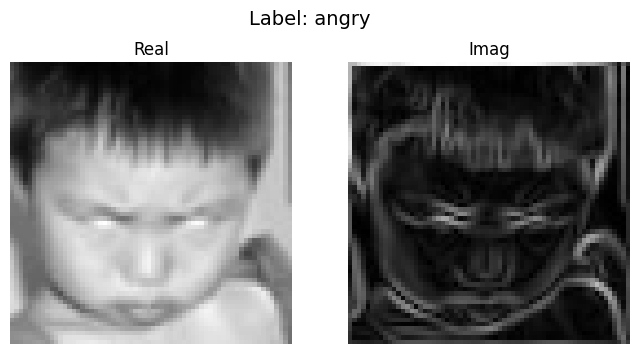

In [80]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Take one sample from dataset
img_tensor, label = full_dataset[0]  # (C,H,W), label

# Make sure it's a single-channel tensor
img_tensor = img_tensor[0:1, :, :].unsqueeze(0)  # (1,1,H,W) for batch dimension

# Compute Sobel edges
def sobel_edges(x: torch.Tensor) -> torch.Tensor:
    sobel_x = torch.tensor([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=torch.float32).view(1,1,3,3)
    sobel_y = torch.tensor([[-1,-2,-1],[0,0,0],[1,2,1]], dtype=torch.float32).view(1,1,3,3)
    sobel_x = sobel_x.to(x.device)
    sobel_y = sobel_y.to(x.device)
    gx = F.conv2d(x, sobel_x, padding=1)
    gy = F.conv2d(x, sobel_y, padding=1)
    g = torch.sqrt(gx**2 + gy**2 + 1e-6)
    return g

xr = img_tensor
xi = sobel_edges(img_tensor) # sobel edges as imag-part 

# Convert tensors to numpy
real_img = xr.squeeze().numpy()
imag_img = xi.squeeze().numpy()

# Plot
fig, axs = plt.subplots(1, 2, figsize=(8,4))
axs[0].imshow(real_img, cmap="gray")
axs[0].set_title("Real")
axs[0].axis("off")

axs[1].imshow(imag_img, cmap="gray")
axs[1].set_title("Imag")
axs[1].axis("off")

plt.suptitle(f"Label: {full_dataset.classes[label]}", fontsize=14)
plt.show()


In [83]:
# ======================
# Device & Model
# ======================
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = ComplexFERNet(num_classes=num_classes)

# If you later want true multi-GPU, consider DDP instead of DataParallel
if torch.cuda.device_count() > 1:
    print(f"Multiple GPUs detected: {torch.cuda.device_count()}")
    model = nn.DataParallel(model)
model = model.to(device)

# ======================
# Loss & Optimizer
# ======================
class_weights = torch.tensor(class_sample_count.sum() / np.maximum(class_sample_count, 1),
                             dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

# ======================
# AMP GradScaler
# ======================
scaler = torch.amp.GradScaler(enabled=(device.type == "cuda"))

# ======================
# Training Loop with Early Stopping
# ======================
epochs = 50
patience = 7
best_val_acc = 0.0
epochs_no_improve = 0

for epoch in range(epochs):
    # --- Training ---
    model.train()
    running_loss, train_total = 0.0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type=device.type, enabled=(device.type == "cuda")):
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * imgs.size(0)
        train_total += imgs.size(0)

    scheduler.step()
    train_loss = running_loss / max(train_total, 1)

    # --- Validation ---
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= max(val_total, 1)
    val_acc = val_correct / max(val_total, 1)

    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_loss:.4f} "
          f"Val Loss: {val_loss:.4f} "
          f"Val Acc: {val_acc*100:.2f}% "
          f"LR: {current_lr:.6f}")

    # --- Early Stopping & Best Model ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), "complex_fer_best.pth")
        print("💾 Saved best model!")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"⏹ Early stopping after {patience} epochs without improvement.")
            break

print("✅ Training complete")


Using device: cuda
Multiple GPUs detected: 2
Epoch [1/50] Train Loss: 1.2173 Val Loss: 2.0949 Val Acc: 6.53% LR: 0.000300
💾 Saved best model!
Epoch [2/50] Train Loss: 0.9543 Val Loss: 1.8134 Val Acc: 13.95% LR: 0.000299
💾 Saved best model!
Epoch [3/50] Train Loss: 0.8504 Val Loss: 1.7257 Val Acc: 20.43% LR: 0.000297
💾 Saved best model!
Epoch [4/50] Train Loss: 0.7661 Val Loss: 1.7283 Val Acc: 22.95% LR: 0.000295
💾 Saved best model!
Epoch [5/50] Train Loss: 0.7410 Val Loss: 1.7207 Val Acc: 21.04% LR: 0.000293
Epoch [6/50] Train Loss: 0.7075 Val Loss: 1.6957 Val Acc: 23.62% LR: 0.000290
💾 Saved best model!
Epoch [7/50] Train Loss: 0.6700 Val Loss: 1.6716 Val Acc: 25.90% LR: 0.000286
💾 Saved best model!
Epoch [8/50] Train Loss: 0.6612 Val Loss: 1.7222 Val Acc: 24.59% LR: 0.000282
Epoch [9/50] Train Loss: 0.6455 Val Loss: 1.6843 Val Acc: 32.03% LR: 0.000277
💾 Saved best model!
Epoch [10/50] Train Loss: 0.6477 Val Loss: 1.7437 Val Acc: 27.81% LR: 0.000271
Epoch [11/50] Train Loss: 0.6449 Va

In [ ]:
# ======================
# Inference helper
# ======================
import torch.nn.functional as F
idx_to_class = {v:k for k, v in val_dataset.dataset.class_to_idx.items()}

def predict_image(img_tensor: torch.Tensor):
    """
    img_tensor: (1, H, W) normalized like validation transform
    """
    model.eval()
    with torch.no_grad():
        img_tensor = img_tensor.unsqueeze(0).to(device)
        logits = model(img_tensor)
        probs = F.softmax(logits, dim=1)[0]
        top_p, top_i = probs.topk(3)
        return [(idx_to_class[i.item()], p.item()) for i, p in zip(top_i, top_p)]

In [85]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import torch

# ======================
# Test dataset
# ======================
test_dir = "/kaggle/input/fer2013/test"

transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

test_dataset = datasets.ImageFolder(test_dir, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

# ======================
# Load best model
# ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ComplexFERNet(num_classes=len(test_dataset.classes))
checkpoint_path = "complex_fer_best.pth"
state_dict = torch.load(checkpoint_path, map_location=device)

# If saved with DataParallel, remove 'module.' prefix
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace("module.", "")  # remove `module.` prefix
    new_state_dict[name] = v

model.load_state_dict(new_state_dict)
model.to(device)
model.eval()


# ======================
# Evaluation
# ======================
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Classification report
report = classification_report(all_labels, all_preds, target_names=test_dataset.classes)
print("Classification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)


Classification Report:
               precision    recall  f1-score   support

       angry       0.35      0.38      0.36       958
     disgust       0.59      0.46      0.52       111
        fear       0.31      0.22      0.26      1024
       happy       0.76      0.51      0.61      1774
     neutral       0.40      0.43      0.42      1233
         sad       0.33      0.40      0.36      1247
    surprise       0.49      0.76      0.60       831

    accuracy                           0.45      7178
   macro avg       0.46      0.45      0.45      7178
weighted avg       0.47      0.45      0.45      7178

Confusion Matrix:
 [[361   8 119  55 139 208  68]
 [ 24  51   9   7  10   7   3]
 [147   3 226  51 129 227 241]
 [124   9  97 900 243 277 124]
 [138   6  90  76 535 266 122]
 [217   8 121  80 229 498  94]
 [ 15   1  64  16  54  47 634]]
